In [158]:
# !bash push.sh

remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 1), reused 3 (delta 1), pack-reused 0
Unpacking objects: 100% (3/3), 1.47 KiB | 214.00 KiB/s, done.
From https://github.com/rachitsaksena/Multilingual-Agression-Classification
   f430b6a..70e5d5b  master     -> origin/master
Updating f430b6a..70e5d5b
Fast-forward
 bangla stop,txt | 362 ++++++++++++++++++++++++++++++++++++++++++++++++++++++++
 1 file changed, 362 insertions(+)
 create mode 100644 bangla stop,txt
[master eebf9ac] Notebook updated.
 1 file changed, 281 insertions(+), 82 deletions(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 4 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 13.01 KiB | 3.25 MiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.c

In [124]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from googletrans import Translator

import spacy
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re
tokenizer = TweetTokenizer(preserve_case=True, strip_handles=True)

In [3]:
eng_train = pd.read_csv('Data/trac2_eng_train.csv')
eng_train.sample(5)

,ID,Text,Sub-task A,Sub-task B
4062,C33.497,Fuck off... Don't u day dare spread homophobia...,OAG,GEN
3259,C10.314,If she is residing abroad and flying in specif...,NAG,NGEN
931,C63.49,gooct,NAG,NGEN
3040,C33.509,I Proud of my self i am Lesbian 🏳️‍🌈,NAG,NGEN
1355,C7.503,Perfect perfect perfect answer for those m.......,OAG,GEN


In [4]:
eng_train.info() # no null enteries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4263 entries, 0 to 4262
Data columns (total 4 columns):
ID            4263 non-null object
Text          4263 non-null object
Sub-task A    4263 non-null object
Sub-task B    4263 non-null object
dtypes: object(4)
memory usage: 133.3+ KB


In [5]:
eng_train.iloc[28].Text, eng_train.iloc[28]['Sub-task A'] 

('feminism means equality not discrimination first you should learn about this\ngo and study about feminism.',
 'OAG')

In [6]:
eng_train[eng_train['Sub-task A'] == 'NAG'].sample(5)

,ID,Text,Sub-task A,Sub-task B
2832,C59.498,Thanks brother,NAG,NGEN
3192,C9.325.1,I know,NAG,NGEN
3875,C10.552,"""Intellectual standard of the one book wonder ...",NAG,NGEN
840,C7.776,Totally Agree with you sir 👌,NAG,NGEN
127,C59.1681,"Bro, Nice video",NAG,NGEN


NAG    3375
CAG     453
OAG     435
Name: Sub-task A, dtype: int64

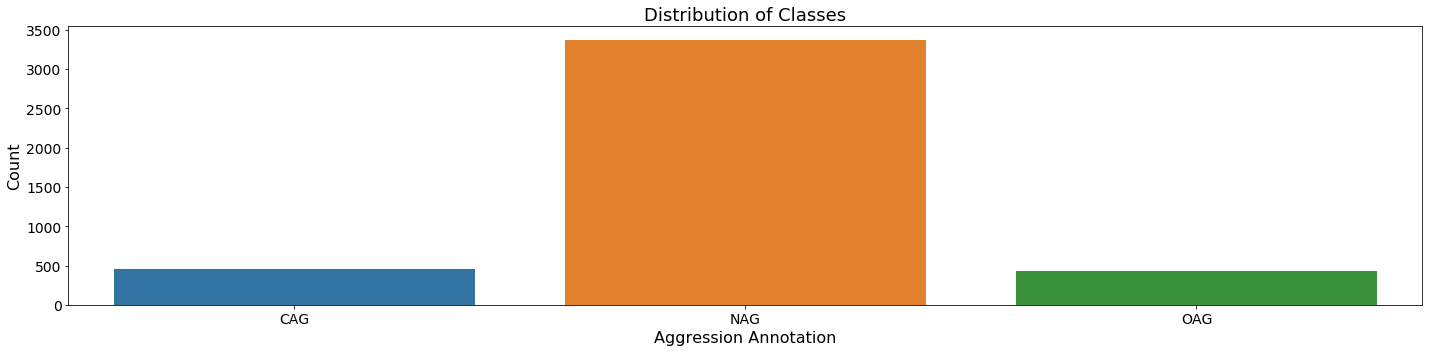

In [7]:
def barplot(df, x, y, title, label, ylabel, dim, orient = "v", ci = False, hue = None):
    
    plt.figure(figsize = dim, facecolor = "white")
    sns.barplot(x = x, y = y, data = df, orient = orient, ci = ci, hue = hue)
    plt.title(f"{title}", size = 18)
    plt.xlabel(f"{label}", size = 16)
    plt.ylabel(f"{ylabel}", size = 16)
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    plt.tight_layout();
    

df = (eng_train.set_index(['ID', 'Sub-task A']).count(level='Sub-task A'))

barplot(df = df,
        x = df.index,
        y = "Text",
        title = "Distribution of Classes",
        label = "Aggression Annotation",
        ylabel = "Count",
        dim = (20,5))

eng_train['Sub-task A'].value_counts()

## CLEANING

      POS  Frequency
0     ADJ       6094
1    NOUN      17789
2   SPACE       4237
3       X        714
4   PROPN       5613
5    PRON       5948
6   PUNCT       8710
7    VERB      14942
8    PART       1319
9     ADP       7175
10    DET       7297
11  CCONJ       2453
12    ADV       5643
13   INTJ        733
14    AUX        159
15    NUM        832
16    SYM        273

Part-of-speech tagging counts for combined corpus


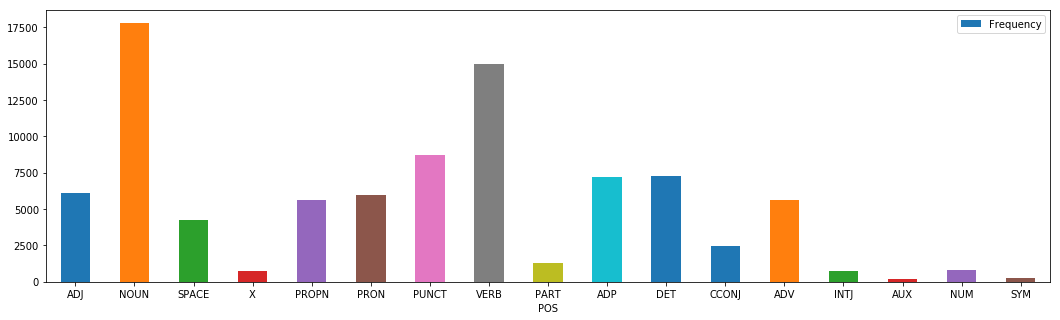

In [122]:
def POS(df):
    total_tokens = []
    freq = {}
    for text in df['Text']:
        doc = nlp(text)
        tokens = []
        for word in doc:
            pos = word.pos_
            if (pos in freq): 
                freq[pos] += 1
            else: 
                freq[pos] = 1
            tokens.append(pos)

        total_tokens.append(tokens)
    pos_df = pd.DataFrame({'POS': list(freq.keys()), 'Frequency':list(freq.values())})
    return pos_df

pos_df = POS(eng_train)
print(pos_df)
print('\nPart-of-speech tagging counts for combined corpus')
pos_df.plot.bar(x ='POS', y ='Frequency', rot = 0, figsize=(18,5))

In [155]:
def fetch_stopwords(url):
    stop = pd.read_csv(url, sep='\n', header=0, names=['words'])
    stop = stop['words'].values.tolist()
    return stop

In [159]:
# STOPWORDS

# from stopwordsiso import stopwords
# bangla_stopwords = stopwords('bn')

hinglish_stopwords = fetch_stopwords('https://raw.githubusercontent.com/TrigonaMinima/HinglishNLP/master/data/assets/stop_hinglish')
english_stopwords = set(stopwords.words('english') + hinglish_stopwords)
hindi_stopwords = set(fetch_stopwords('https://raw.githubusercontent.com/TrigonaMinima/HinglishNLP/master/data/assets/stop_hindi'))
bangla_stopwords = set(fetch_stopwords(''))

HTTPError: HTTP Error 404: Not Found

In [ ]:
stop_dict = {'en': english_stopwords,
             'hi': hindi_stopwords,
             'bn': bangla_stopwords}

In [87]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001F923"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [ ]:
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [123]:

def clean_text(df, lang):
    stop_words = stop_dict[lang]
    for sentence in df["clean text"]:
        sentence = remove_emoji(sentence)
        sentence = re.sub(r"([.!?])", r" \1", sentence)
        sentence = re.sub(r'[/(){}\[\]\|@,;:.]', r'', str(sentence))
        sentence = re.sub(r"[^a-z]+", r"", sentence)
        sentence = ' '.join(word for word in sentence.split() if word not in stop_words and len(word)>2)
    df["tokenized"] = [tokenize_text(text) for text in df['Text']]
    return df

## LANGUAGE TAGGING

In [114]:
def lang_tag(df):
    for text in df.Text:
        df['Tag'] = text.split()
        